In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import glob
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa # librosa: Audio handling package
import random
import copy
import re
import jamotools

from tqdm import tqdm_notebook as tqdm # tqdm: Pakage for progress bar visualization
from datetime import datetime

import threading
import queue

import Levenshtein as Lev

In [2]:
n_mels = 80
fs = 16000
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

# meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
# data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'

# meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
# data_folder = "D:/korean-single-speaker-speech-dataset/kss"

data_folder = "D:/nsml-dataset/train_data/"
label_path = "D:/nsml-dataset/hackathon.labels"

data_list = glob.glob(data_folder + '*.csv')[0]

wav_paths = list()
script_paths = list()
korean_script_paths = list()

with open(data_list, 'r') as f:
    for line in f:
        # line: "aaa.wav,aaa.label"
        wav_path, script_path = line.strip().split(',')
        korean_script_path = script_path.replace('.label', '.script')
        
        wav_paths.append(os.path.join(data_folder, wav_path))
        script_paths.append(os.path.join(data_folder, script_path))
        korean_script_paths.append(os.path.join(data_folder, korean_script_path))

dataset_size = len(wav_paths)

In [3]:
def get_label(filepath, bos_id, eos_id):
    key = filepath.split('/')[-1].split('.')[0]
    script = target_dict[key]
    tokens = script.split(' ')
    result = list()
    result.append(bos_id)
    for i in range(len(tokens)):
        if len(tokens[i]) > 0:
            result.append(int(tokens[i]))
    result.append(eos_id)
    return result

In [4]:
print("wav_paths len: {}".format(len(wav_paths)))
print("script_paths len: {}".format(len(script_paths)))
print("korean_script_paths len: {}".format(len(korean_script_paths)))

print(wav_paths[0])
print(script_paths[0])
print(korean_script_paths[0])

wav_paths len: 29805
script_paths len: 29805
korean_script_paths len: 29805
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.wav
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.label
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.script


In [5]:
with open(script_paths[1]) as f:
    line = f.read()
    line = line.strip()
    result = list(map(int, line.split(' ')))

In [6]:
def load_label(label_path):
    char2index = dict() # [ch] = id
    index2char = dict() # [id] = ch
    with open(label_path, 'r', encoding='UTF-8') as f:
    # with open(label_path, 'r') as f:
        for no, line in enumerate(f):
            if line[0] == '#': 
                continue

            index, char, freq = line.strip().split('\t')
            char = char.strip()
            if len(char) == 0:
                char = ' '

            char2index[char] = int(index)
            index2char[int(index)] = char

    return char2index, index2char

In [7]:
char2index, index2char = load_label(label_path)
SOS_token = char2index['<s>']  # '<sos>' or '<s>'
EOS_token = char2index['</s>']  # '<eos>' or '</s>'
PAD_token = char2index['_']  # '-' or '_'

In [10]:
print('char2index len: {}'.format(len(char2index)))

print('index2char len: {}'.format(len(index2char)))

char2index len: 820
index2char len: 820


In [8]:
pure_jamo_list = list()

# 초성
for unicode in range(0x1100, 0x1113):
    pure_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# 중성
for unicode in range(0x1161, 0x1176):
    pure_jamo_list.append(chr(unicode))
# 종성
for unicode in range(0x11A8, 0x11C3):
    pure_jamo_list.append(chr(unicode))

pure_jamo_list += [' ', '!', ',', '.', '?']

print(pure_jamo_list)

['ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ', ' ', '!', ',', '.', '?']


In [9]:
korean_script_list = list()
jamo_script_list = list()

# true_jamo_regex_not  = re.compile(u'[^, .?!\u1100-\u115e\u1161-\u11A7\u11a8-\u11ff]+')

# valid_regex = re.compile(u'[,_ ^.?!？~<>:;/%()+A-Za-z0-9\u1100-\u115e\u1161-\u11A7\u11a8-\u11ff]+')

count = 0

for file in tqdm(korean_script_paths):
    with open(file, 'r', encoding='utf-8') as f:
        line = f.read()
        line = line.strip()
        korean_script_list.append(line)
        jamo = list(jamotools.split_syllables(line, 'JAMO'))
        
#         print(len(jamo))
        for i, c in enumerate(jamo):
            if c not in pure_jamo_list:
                jamo[i] = '*'
        
        jamo = ''.join(jamo)
#         jamo_filtered = ''.join(true_jamo_regex.findall(jamo))
#         jamo_filtered = re.sub(true_jamo_regex_not, '*', jamo)
        jamo_script_list.append(jamo)
        
#         print(line)
#         print(jamo) 
        
#         if count == 100:
#             break
        
#         count += 1

In [10]:
def find_starting_point(coef, thres = 0.1, margin = 10):
    starting_point = 0
    for i in range(len(coef) - 1):
        if (coef[i] <= thres and coef[i+1] > thres):
            starting_point = i
            break
            
    starting_point = starting_point - margin
    
    if starting_point < 0:
        starting_point = 0
    
    return starting_point

def find_ending_point(coef, thres = 0.1, margin = 10):
    for i in range(len(coef) - 1, 0, -1):
        if (coef[i] <= thres and coef[i-1] > thres):
            ending_point = i
            break
            
    ending_point = ending_point + margin
    
    if ending_point > len(coef):
        ending_point = len(coef)

    return ending_point

In [11]:
class Threading_Batched_Preloader():
    def __init__(self, wav_path_list, ground_truth_list, script_path_list, batch_size, is_train=True):
        super(Threading_Batched_Preloader).__init__()
        self.wav_path_list = wav_path_list
        self.total_num_input = len(wav_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.script_path_list = script_path_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = False
        self.batch_size = batch_size
        self.queue = queue.Queue(16)
        self.thread_flags = list()
        self.is_train = is_train
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self, thread_num):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])

        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        loading_sequence_len = len(loading_sequence)
        
#         print("Loading Sequence Length: {}".format(loading_sequence_len))
        
        thread_size = int(np.ceil(loading_sequence_len / thread_num))

        load_idxs_list = list()
        for i in range(thread_num):
            start_idx = i * thread_size
            end_idx = (i + 1) * thread_size

            if end_idx > loading_sequence_len:
                end_idx = loading_sequence_len

            load_idxs_list.append(loading_sequence[start_idx:end_idx])
            
#         for i in range(thread_num):
#             print(len(load_idxs_list[i]))

        self.end_flag = False
        
        self.queue = queue.Queue(32)
        self.thread_flags = [False] * thread_num
        
        self.thread_list = [Batching_Thread(self.wav_path_list, self.ground_truth_list, self.script_path_list, load_idxs_list[i], self.queue, self.batch_size, self.thread_flags, i, self.is_train) for i in range(thread_num)]

        for thread in self.thread_list:
            thread.start()
        return

    def check_thread_flags(self):
        for flag in self.thread_flags:
            if flag == False:
                return False
        
        if (self.queue.empty):
            self.end_flag = True
            return True

        return False

    def get_batch(self):
        while not (self.check_thread_flags()):
            batch = self.queue.get()

            if (batch != None):
                batched_tensor = batch[0]
                batched_ground_truth = batch[1] 
                batched_loss_mask = batch[2]
                ground_truth_size_list = batch[3]
                lev_truth_list = batch[4]

                return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list, lev_truth_list

        return None

class Batching_Thread(threading.Thread):

    def __init__(self, wav_path_list, ground_truth_list, script_path_list, load_idxs_list, queue, batch_size, thread_flags, id, is_train=True):
        
        threading.Thread.__init__(self)
        self.wav_path_list = wav_path_list
        self.ground_truth_list = ground_truth_list
        self.script_path_list = script_path_list
        self.load_idxs_list = load_idxs_list
        self.list_len = len(load_idxs_list)
        self.cur_idx = 0
        self.id = id
        self.queue = queue
        self.batch_size = batch_size 
        self.thread_flags = thread_flags
        self.is_train = is_train

    def run(self):

        while(self.cur_idx < self.list_len):
            batch = self.batch()
            success = False
            while success == False:
                try:
                    self.queue.put(batch, True)
                    success = True
                except:
                    print("Batching Failed in Thread ID: {}".format(self.id))
                    sleep(1)

        self.thread_flags[self.id] = True
        
#         print("Thread {} finished".foramt(self.id))

        return 


    def batch(self):

        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        lev_truth_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.cur_idx >= self.list_len:
                self.end_flag = True
                break
                
            script_path = self.script_path_list[self.load_idxs_list[self.cur_idx]]
            
#             print(script_path)
            
            with open(script_path) as f:
                line = f.read()
                line = line.strip()
                lev_truth = list(map(int, line.split(' ')))
                
            lev_truth_list.append(lev_truth)
            
            wav_path = self.wav_path_list[self.load_idxs_list[self.cur_idx]]

            tensor = self.create_mel(wav_path)
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.load_idxs_list[self.cur_idx]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.cur_idx += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
            
            if self.is_train:
                pad_random = np.random.randint(0, 5)
                # Time shift, add zeros in front of an image
                if pad_random > 0:
                    offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                    target = torch.cat((offset, target), 1)
                # Add random noise
                target = target + (torch.rand(target.shape) - 0.5) / 20
                # Value less than 0 or more than 1 is clamped to 0 and 1
                target = torch.clamp(target, min=0.0, max=1.0)
                batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            else:
                batched_tensor[order, :tensor_size_list[order], :] = target

#           batched_tensor[order, :tensor_size_list[order], :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return [batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list, lev_truth_list]
    
    def create_mel(self, wav_path):  
        y, sr = librosa.core.load(wav_path, sr=fs) 
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        
        # Cut-off paddings
        coef = np.sum(Sxx, 0)
        Sxx = Sxx[:, find_starting_point(coef):find_ending_point(coef)]

        # mel_filters: (n_fft, n_mels)
        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

        # log10(0) is minus infinite, so replace mel_specgram values smaller than 'eps' as 'eps' (1e-8)
        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        
        # 20 * log10(eps) = 20 * -8 = -160
        # -160 is the smallest value
        # Add 160 and divide by 160 => Normalize value between 0 and 1
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref        
        
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        return tensor_input

In [12]:
# Tokenizer maps numbers to characters, 8 -> 'ㄱ', 10 -> 'ㄴ'
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [13]:
# unicode_jamo_list = list()

# # 초성
# for unicode in range(0x1100, 0x1113):
#     unicode_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# # 중성
# for unicode in range(0x1161, 0x1176):
#     unicode_jamo_list.append(chr(unicode))
# # 종성
# for unicode in range(0x11A8, 0x11C3):
#     unicode_jamo_list.append(chr(unicode))
# for unicode in range(ord('A'), ord('Z') + 1):
#     unicode_jamo_list.append(chr(unicode))
# for unicode in range(ord('a'), ord('z') + 1):
#     unicode_jamo_list.append(chr(unicode))
# for unicode in range(ord('0'), ord('9') + 1):
#     unicode_jamo_list.append(chr(unicode))

# unicode_jamo_list += [' ', '\\', '!', '~', '^', '<', '>', ',', '.', "'", '?', '？', '/', '%', '(', ')', ':', ';', '+',
#                       '-', '<s>', '</s>']
# unicode_jamo_list.sort()
# # '_' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
# unicode_jamo_list = ['_'] + unicode_jamo_list

# tokenizer = Tokenizer(unicode_jamo_list)
# jamo_tokens = tokenizer.word2num(unicode_jamo_list)

unicode_jamo_list = list()

# 초성
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# 중성
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
# 종성
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))

unicode_jamo_list += [' ', '!', ',', '.', '?', '<s>', '</s>', '*']

unicode_jamo_list.sort()
# '_' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
unicode_jamo_list = ['_'] + unicode_jamo_list

tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [14]:
print(unicode_jamo_list)
print(jamo_tokens)

['_', ' ', '!', '*', ',', '.', '</s>', '<s>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]


In [15]:
ground_truth_list = [(tokenizer.word2num(['<s>'] + list(jamo_script_list[i]) + ['</s>'])) for i in range(len(jamo_script_list))]

In [16]:
# 90% of the data will be used as train
split_index = int(0.9 * len(wav_paths))

wav_path_list_train = wav_paths[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]
script_path_list_train = script_paths[:split_index]

wav_path_list_eval = wav_paths[split_index:]
ground_truth_list_eval = ground_truth_list[split_index:]
script_path_list_eval = script_paths[split_index:]

In [17]:
batch_size = 32
num_thread = 3

preloader_eval = Threading_Batched_Preloader(wav_path_list_eval, ground_truth_list_eval, script_path_list_eval, batch_size, is_train=False)
preloader_train = Threading_Batched_Preloader(wav_path_list_train, ground_truth_list_train, script_path_list_train, batch_size)

In [18]:
def train(net, optimizer, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.train()
    
    batch_size = input_tensor.shape[0]

    optimizer.zero_grad()
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    loss.backward()
    optimizer.step()

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]


def evaluate(net, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.eval()
    
    batch_size = input_tensor.shape[0]
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]

def save(model, optimizer, check_point_name):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, check_point_name)

def load(model, optimizer, check_point_name):
    checkpoint = torch.load(check_point_name)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [19]:
# Use GPU if GPU is available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
        # (B, T, F)
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        # (B, T, H)
        output_tensor, _ = self.gru(output_tensor)
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out, num_chars):
        super(CTC_Decoder, self).__init__()
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.2) 
        self.gru = nn.GRU(H, D_out, batch_first=True)
        self.fc = nn.Linear(D_out, num_chars)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):
        # (B, T, 2 * H/2)
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor) 
        # (B, T, H)
        output_tensor,_ = self.gru(input_tensor)
        # (B, T, H)
        output_tensor = self.fc(output_tensor)
        # (B, T, 75)
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet(nn.Module):
    def __init__(self, D_in, H, D_out, num_chars, device):
        super(Mel2SeqNet, self).__init__()
        
        self.encoder = Encoder(D_in, H).to(device)
        self.decoder = CTC_Decoder(H, D_out, num_chars).to(device)
        
        # Initialize weights with random uniform numbers with range
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def forward(self, input_tensor):
        batch_size = input_tensor.shape[0]
        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)
        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        return pred_tensor

In [ ]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
############################################################################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(hidden_size, int(hidden_size/2), bidirectional=True)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        return output, hidden

    def initHidden(self, batch_size):
          return torch.zeros(2, batch_size, int(self.hidden_size/2), device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, len(jamo_tokens))

    def forward(self, embedded, hidden, encoder_outputs):

        embedded = self.dropout(embedded)
        
        # (1, B, H) + (1, B, H) = (1, B, 2H)        
        concated_tensor = torch.cat((embedded, hidden), 2)
        
        key = self.attn(concated_tensor) # (1, B, H)
        key = key.permute(1, 2, 0) # (B, H, 1)

        attention_value = torch.bmm(encoder_outputs, key) # (B, L, 1)
        attn_weights = F.softmax(attention_value, dim=1)
        
        attn_weights = attn_weights.permute(0, 2, 1) # (B, 1, L)
        attn_applied = torch.bmm(attn_weights, encoder_outputs) # (B, 1, H)
        attn_applied = attn_applied.permute(1, 0, 2) # (1, B, H)
        
        output = torch.cat((embedded, attn_applied), 2) # (1, B, 2H)
        output = self.attn_combine(output) # (1, B, H)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden) # (1, B, H)
        output = F.log_softmax(self.out(output), dim=2) # (1, B, 74)
        
        return output.squeeze(0), hidden, attn_weights.squeeze(1)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
class Seq2SeqNet(nn.Module):
    def __init__(self, hidden_size, jamo_tokens, index2char):
        super(Seq2SeqNet, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.embedding_layer = nn.Embedding(len(jamo_tokens), hidden_size).to(device) 
        self.embedding_layer_2 = nn.Embedding(len(index2char), hidden_size).to(device)
        self.encoder = EncoderRNN(hidden_size).to(device)
        self.decoder = AttnDecoderRNN(hidden_size,len(index2char), dropout_p=0.1).to(device)
        
        self.embedding_optimizer = optim.SGD(self.embedding_layer.parameters(), lr=0.001)  
        self.embedding_optimizer_2 = optim.SGD(self.embedding_layer_2.parameters(), lr=0.001)  
        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)

        self.criterion = nn.NLLLoss(reduction='none')
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer_2.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
def train(self, input_tensor, target_tensor, loss_mask):

    self.embedding_optimizer.zero_grad()
    self.embedding_optimizer_2.zero_grad()
    self.encoder_optimizer.zero_grad()
    self.decoder_optimizer.zero_grad()

    batch_size = input_tensor.shape[0]
    input_length = input_tensor.shape[1]
    target_length = target_tensor.shape[1]

#       input_tensor = torch.cuda.LongTensor(input_tensor.long().to(device))
    input_tensor = torch.cuda.LongTensor(input_tensor.long())
    target_tensor = torch.cuda.LongTensor(target_tensor.long())

    embedded_tensor = self.embedding_layer(input_tensor)

    embedded_tensor = embedded_tensor.permute(1, 0, 2)

    # (L, B)
    target_tensor = target_tensor.permute(1, 0)

    encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

    loss = 0

    encoder_hidden = self.encoder.initHidden(batch_size)

    for ei in range(input_length):
        embedded_slice = embedded_tensor[ei].unsqueeze(0)
        encoder_output, encoder_hidden = self.encoder(
            embedded_slice, encoder_hidden)
        encoder_outputs[ei] = encoder_output

    decoder_input_token = torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).long().unsqueeze(0).to(device)


    # Override encoder hidden state
    encoder_hidden = encoder_outputs[-1, :, :].unsqueeze(0)

    # (L, B, H) -> (B, L, H)
    encoder_outputs = encoder_outputs.permute(1, 0, 2)

    # Override encoder_hidden
    decoder_hidden = encoder_hidden

    decoder_attentions = torch.zeros([batch_size, input_length, target_length])
    decoder_outputs = torch.zeros([batch_size, target_length, len(jamo_tokens)])

    for di in range(target_length):
        decoder_input = self.embedding_layer_2(decoder_input_token)

        decoder_output, decoder_hidden, decoder_attention = self.decoder(
            decoder_input, decoder_hidden, encoder_outputs)

        loss += torch.mean(self.criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])

        if np.random.rand() < 0.8:        
            decoder_input_token = target_tensor[di].unsqueeze(0)
        else:
            decoder_input_token = torch.argmax(decoder_output, dim=1).unsqueeze(0)

        decoder_attentions[:, :, di] = decoder_attention
        decoder_outputs[:, di, :] = decoder_output

#       print(decoder_output.shape)

    loss.backward()

    self.embedding_optimizer.step()
    self.embedding_optimizer_2.step()
    self.encoder_optimizer.step()
    self.decoder_optimizer.step()

    return decoder_outputs, decoder_attentions, loss.item() / target_length



def evaluate(self, input_tensor, target_tensor, loss_mask):

    batch_size = input_tensor.shape[0]
    input_length = input_tensor.shape[1]
    target_length = target_tensor.shape[1]

    input_tensor = torch.cuda.LongTensor(input_tensor.long())
    target_tensor = torch.cuda.LongTensor(target_tensor.long())

    embedded_tensor = self.embedding_layer(input_tensor)
    embedded_tensor = embedded_tensor.permute(1, 0, 2)

    # (L, B)
    target_tensor = target_tensor.permute(1, 0)

    encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

    loss = 0

    encoder_hidden = self.encoder.initHidden(batch_size)

    for ei in range(input_length):
        embedded_slice = embedded_tensor[ei].unsqueeze(0)
        encoder_output, encoder_hidden = self.encoder(
            embedded_slice, encoder_hidden)
        encoder_outputs[ei] = encoder_output

    decoder_input_token = torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).long().unsqueeze(0).to(device)

    # Override encoder hidden state
    encoder_hidden = encoder_outputs[-1, :, :].unsqueeze(0)

    # (L, B, H) -> (B, L, H)
    encoder_outputs = encoder_outputs.permute(1, 0, 2)

    decoder_hidden = encoder_hidden

    decoder_attentions = torch.zeros([batch_size, input_length, target_length])
    decoder_outputs = torch.zeros([batch_size, target_length, len(jamo_tokens)])

    for di in range(target_length):
        decoder_input = self.embedding_layer_2(decoder_input_token)

        decoder_output, decoder_hidden, decoder_attention = self.decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        loss += torch.mean(self.criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])

        # decoder_input_token = target_tensor[di].unsqueeze(0)
        decoder_input_token = torch.argmax(decoder_output, dim=1).unsqueeze(0)

        decoder_attentions[:, :, di] = decoder_attention
        decoder_outputs[:, di, :] = decoder_output


    return decoder_outputs, decoder_attentions, loss.item() / target_length

def save(self, check_point_name):
    torch.save({
        'embedding_layer_state_dict': self.embedding_layer.state_dict(),
        'embedding_layer_2_state_dict': self.embedding_layer_2.state_dict(),
        'encoder_state_dict': self.encoder.state_dict(),
        'decoder_state_dict': self.decoder.state_dict(),
        'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
        'embedding_optimizer_2_state_dict': self.embedding_optimizer_2.state_dict(),
        'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
        'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
        }, check_point_name)

def load(self, check_point_name):
    checkpoint = torch.load(check_point_name)
    self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
    self.embedding_layer_2.load_state_dict(checkpoint['embedding_layer_2_state_dict'])
    self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
    self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
    self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
    self.embedding_optimizer_2.load_state_dict(checkpoint['embedding_optimizer_2_state_dict'])
    self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])

def set_mode(self, mode):

    if mode == 'train':
        self.embedding_layer.train()
        self.embedding_layer_2.train()
        self.encoder.train()
        self.decoder.train()

    elif mode == 'eval':
        self.embedding_layer.eval()
        self.embedding_layer_2.eval()
        self.encoder.eval()
        self.decoder.eval()

    else:
        print("Invalid mode string: {}".format(mode))
    
net = Seq2SeqNet(256)

In [20]:
# Function that interprets the CTC prediction result

def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem

    result = np.asarray(result)
    
    return result

In [21]:
# def label_to_string(labels):
#     if len(labels.shape) == 1:
#         sent = str()
#         for i in labels:
#             if i.item() == EOS_token:
#                 break
#             sent += index2char[i.item()]
#         return sent

#     elif len(labels.shape) == 2:
#         sents = list()
#         for i in labels:
#             sent = str()
#             for j in i:
#                 if j.item() == EOS_token:
#                     break
#                 sent += index2char[j.item()]
#             sents.append(sent)

#         return sents
    
def lev_num_to_lev_string(lev_num_list, index2char):
    lev_str_list = list()
    for num_list in lev_num_list:
        
        temp = list()
        for num in num_list:
            temp.append(index2char[num])
        
        lev_str_list.append(''.join(temp))

    return lev_str_list

def char_distance(ref, hyp):
    ref = ref.replace(' ', '') 
    hyp = hyp.replace(' ', '') 

    dist = Lev.distance(hyp, ref)
    length = len(ref.replace(' ', ''))

    return dist, length 

def char_distance_list(ref_list, hyp_list):

    sum_dist = 0
    sum_length = 0
    
    for ref, hyp in zip(ref_list, hyp_list):
        dist, length = char_distance(ref, hyp)
        sum_dist += dist
        sum_length += length

    return sum_dist, sum_length 

# def get_distance(ref_labels, hyp_labels, display=False):
#     total_dist = 0
#     total_length = 0
#     for i in range(len(ref_labels)):
#         ref = label_to_string(ref_labels[i])
#         hyp = label_to_string(hyp_labels[i])
#         dist, length = char_distance(ref, hyp)
#         total_dist += dist
#         total_length += length 
#         if display:
#             cer = total_dist / total_length
#             print('%d (%0.4f)\n(%s)\n(%s)' % (i, cer, ref, hyp))
#     return total_dist, total_length

In [22]:
# def c2i_decoding(c2i, sentence):
#     tokens = list()
#     for char in sentence:
#         try:
#             tokens.append(c2i[char])   
#         except:
# #             print(char)
#             pass
#     return tokens

def Decode_Prediction(pred_tensor, tokenizer, char2index):
    decoded_list = list()
    for i in range(pred_tensor.shape[1]):
        _, CTC_index = pred_tensor[:, i, :].max(-1)
        index = Decode_CTC_Prediction(CTC_index)
        jamos = tokenizer.num2word(index)
        sentence = jamotools.join_jamos(''.join(jamos))
        
        not_com_jamo = re.compile(u'[^\u3130-\u3190]')
        filtered_sentence = ''.join(not_com_jamo.findall(sentence))
        filtered_sentence = filtered_sentence.replace('<s>', '')
        filtered_sentence = filtered_sentence.replace('</s>', '')
#         filtered_sentence = filtered_sentence.replace('<eos>', '')
#         final_prediction = c2i_decoding(char2index, filtered_sentence)
        
        decoded_list.append(filtered_sentence)
    return decoded_list

09-22 20:15:11
09-22 20:17:42
Mean Train Loss: 0.009435506005138997
Train CER: 0.2587089616423995
09-22 20:17:58
Mean Evaluation Loss: 0.016808557801753457
Evaluation CER: 0.34164360276330985


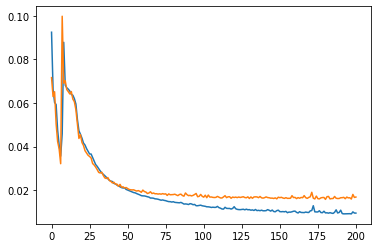

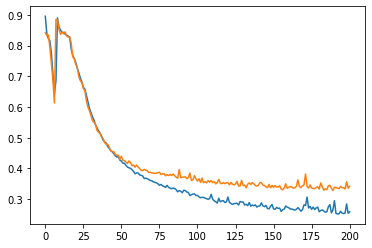

<s>아__________________ᆫᆫ녀_ᆼᆼᄒ하__세___요________유_요__ᆼ_ *______시___비__에___   오____푸_ᆫ__리____예_ᄋ_ᄋ야ᅣᆨᆨ_을 해__너_ᆫ  가__여____느_ᆫ__데________________________________ _ᅩ__시_____시__가_ᆫ__데__ 벼___ᆫ_겨__ᆼᆼ_ 가___ᄂ느_______________________ᆼᆼ하_ᆫ가요??</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>
<s>안녕하세요유용 *시비에 오푼리예ᄋ약을 해넌 가여는데 ᅩ시시간데 변경 가능한가요

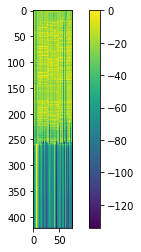

<s>네______________________________________________________  이____워_____에____________ᅥ______시_____이______뉴__로__________________며_______하____이__ 싶__테____ᆸ__츠_____가_____________ _지_____매_____요___로____ _초__가___으_____나____고___ _가___느ᅳ______ᆫ__데_______________________________________   호_ᆨᆨ___시_____________________  이_____니____ 추_______시__가____________________________________________________________________________________________________________________________________________________아__나요??</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>
<s>네 이워에ᅥ시이뉴로며하이 싶텝츠가 지매요로 초가으나고 가는데 혹시 이니 추시가아나요?</s>
<s>네 이번에 *월 신메뉴로 양갈비 스테이크가 신메뉴로 추가된다고 봤는데. 혹시 이미 출시되었나요?</s>_______________________________________________________________


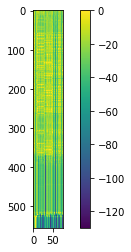

-------------------------------------------------------------------------------------------------------
09-22 20:17:59


KeyboardInterrupt: 

In [23]:
EPOCH = 20 * 10
           
# net = Mel2SeqNet(80, 512, 256)


# net = Mel2SeqNet(80, 1024, 512, len(unicode_jamo_list), device)

keyword = 'NSML_pure_jamo_50ms_pad_cut'
# net = Mel2SeqNet(80, 512, 256, len(unicode_jamo_list), device)

keyword = 'NSML_pure_jamo_50ms_pad_cut_1024'
net = Mel2SeqNet(80, 1024, 512, len(unicode_jamo_list), device)


net_optimizer = optim.Adam(net.parameters(), lr=0.001)

ctc_loss = nn.CTCLoss().to(device)

train_loss_history = list()
eval_loss_history = list()

train_cer_history = list()
eval_cer_history = list()

try:
    train_cer_history = list(np.load('model_saved/train_cer_history_{}.npy'.format(keyword)))
    eval_cer_history = list(np.load('model_saved/eval_cer_history_{}.npy'.format(keyword)))
except:
    print("No CER Record")

try:
    load(net, net_optimizer, 'model_saved/{}'.format(keyword))
    train_loss_history = list(np.load('model_saved/train_loss_history_{}.npy'.format(keyword)))
    eval_loss_history = list(np.load('model_saved/eval_loss_history_{}.npy'.format(keyword)))
except:
    print("Loading {} Error".format(keyword))


for epoch in range(EPOCH):

    print((datetime.now().strftime('%m-%d %H:%M:%S')))

    preloader_train.initialize_batch(num_thread)
    loss_list_train = list()

    total_dist = 0
    total_length = 0
#     count = 0
    net.train()
    
    while preloader_train.end_flag == False:
        batch = preloader_train.get_batch()
        # logger.info("Got Batch")
        if batch != None:
            tensor_input, ground_truth, loss_mask, length_list, lev_truth_list = batch
            pred_tensor, loss = train(net, net_optimizer, ctc_loss, tensor_input.to(device),
                                      ground_truth.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_train.append(loss)
            
            lev_pred_list = Decode_Prediction(pred_tensor, tokenizer, char2index)
            lev_str_list = lev_num_to_lev_string(lev_truth_list, index2char)
            dist, length = char_distance_list(lev_str_list, lev_pred_list)
            total_dist += dist
            total_length += length
            
#             print(loss)
#             _, index = pred_tensor[:, 0, :].max(-1)
#             sentence = tokenizer.num2word(index.view(-1))
#             print(''.join(sentence))
#             index_ = Decode_CTC_Prediction(index)
#             sentence_ = tokenizer.num2word(index_)
#             print(''.join(sentence_))
#             true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
#             print(''.join(true_sentence))
#             print('')
                 
#             print("Loss: {}".format(loss))
#             count += 1
#             print("Train {}/{}".format(count, int(np.ceil(len(wav_path_list_train)/batch_size))))
#             # logger.info("Training")

    train_cer = total_dist / total_length
    train_loss = np.mean(np.asarray(loss_list_train))
    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    print("Mean Train Loss: {}".format(train_loss))
    print("Train CER: {}".format(train_cer))
    train_loss_history.append(train_loss)
    train_cer_history.append(train_cer)
    
    preloader_eval.initialize_batch(num_thread)
    loss_list_eval = list()

    total_dist = 0
    total_length = 0
    
    net.eval()
    
    while preloader_eval.end_flag == False:
        batch = preloader_eval.get_batch()
        if batch != None:
            tensor_input, ground_truth_, loss_mask, length_list, lev_truth_list_ = batch
            pred_tensor_, loss = evaluate(net, ctc_loss, tensor_input.to(device), ground_truth_.to(device),
                                          loss_mask.to(device), length_list.to(device))
            loss_list_eval.append(loss)
            
            lev_pred_list = Decode_Prediction(pred_tensor_, tokenizer, char2index)
            lev_str_list = lev_num_to_lev_string(lev_truth_list_, index2char)
            dist, length = char_distance_list(lev_str_list, lev_pred_list)
            total_dist += dist
            total_length += length
            
    eval_cer = total_dist / total_length
    eval_loss = np.mean(np.asarray(loss_list_eval))
    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    print("Mean Evaluation Loss: {}".format(eval_loss))
    print("Evaluation CER: {}".format(eval_cer))
    eval_loss_history.append(eval_loss)
    eval_cer_history.append(eval_cer)
    
    #####
    
    save(net, net_optimizer, 'model_saved/{}'.format(keyword))
    np.save('model_saved/train_loss_history_{}'.format(keyword), train_loss_history)
    np.save('model_saved/eval_loss_history_{}'.format(keyword), eval_loss_history)
    np.save('model_saved/train_cer_history{}'.format(keyword), train_cer_history)
    np.save('model_saved/eval_cer_history{}'.format(keyword), eval_cer_history)
            
    #####    
    
    plt.figure()
    plt.plot(train_loss_history)
    plt.plot(eval_loss_history)
    plt.show()
    
    plt.figure()
    plt.plot(train_cer_history)
    plt.plot(eval_cer_history)
    plt.show()

    # index is the position of the max probility of the first batch
    # Shape of the pred_tensor: (T, B, 75)
    # Shape of the index: (T)
    _, index = pred_tensor[:, 0, :].max(-1)

    # Change index numbers to character
    sentence = tokenizer.num2word(index.view(-1))

    # Change list to string
    print(''.join(sentence))

    # Remove "blank" and overlapping characters
    index_ = Decode_CTC_Prediction(index)
    sentence_ = tokenizer.num2word(index_)
    print(''.join(sentence_))

    true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
    print(''.join(true_sentence))

    # Plot image
    # detach().cpu().numpy() transforms a tensor on gpu into a numpy matrix
    plt.figure()
    plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
    plt.colorbar()
    plt.show()

    _, index = pred_tensor_[:, 0, :].max(-1)

    sentence = tokenizer.num2word(index.view(-1))
    print(''.join(sentence))
    index_ = Decode_CTC_Prediction(index)
    sentence_ = tokenizer.num2word(index_)
    print(''.join(sentence_))
    true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
    print(''.join(true_sentence))

    plt.figure()
    plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
    plt.colorbar()
    plt.show()
        
    print("-------------------------------------------------------------------------------------------------------")
    
    